## Test Lithology Classification on Unseen Data
### By Mohammad Shehar Yaar Tausif

Dataset link : https://zenodo.org/records/4351156#.YXhFTBrMJPb

In [2]:
# imports
# import warnings
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import shap

/home/wazir/workspace/mtp/Force-2020-Machine-Learning-competition/sheharyaar/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Hidden Dataset

In [3]:
# Load the hidden test dataset
test_df = pd.read_csv('./data/hidden_test.csv', sep=';')
test_df.head()

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,15/9-23,1518.280,433906.75,6460000.5,-1493.241821,HORDALAND GP.,Skade Fm.,15.506232,NaN,NaN,...,146.526276,326.451263,-1.993768,0.109706,NaN,NaN,88.968864,NaN,65000,3.0
1,15/9-23,1518.432,433906.75,6460000.5,-1493.393799,HORDALAND GP.,Skade Fm.,18.524611,NaN,NaN,...,147.605148,322.926361,1.024611,-0.006418,NaN,NaN,92.287186,NaN,65000,3.0
2,15/9-23,1518.584,433906.75,6460000.5,-1493.545776,HORDALAND GP.,Skade Fm.,18.855669,NaN,NaN,...,140.783127,325.283142,1.355668,0.022769,NaN,NaN,95.605499,NaN,65000,3.0
3,15/9-23,1518.736,433906.75,6460000.5,-1493.697754,HORDALAND GP.,Skade Fm.,19.163353,NaN,NaN,...,125.159531,334.233185,1.663353,0.024972,NaN,NaN,98.923820,NaN,65000,3.0
4,15/9-23,1518.888,433906.75,6460000.5,-1493.849609,HORDALAND GP.,Skade Fm.,18.489744,NaN,0.849849,...,107.576691,330.952362,0.989743,0.024527,NaN,NaN,102.242142,NaN,65000,3.0


In [4]:
# these values are provided by the dataset (https://thinkonward.com/app/c/challenges/force-well-logs/overview)
lithology_keys = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'}

display_labels = list(lithology_keys.values())
lithology_codes = list(lithology_keys.keys())

### Load the joblib pipeline

In [5]:
import joblib
pipeline = joblib.load('xgboost_pipeline_mtp.joblib')
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['DEPTH_MD', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR',
       'SGR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO',
       'MUDWEIGHT', 'RMIC', 'ROPA', 'RXO', 'GR_NORM', 'RES_RATIO', 'ND_SEP',
       'ROLL_GR', 'REL_DEPTH'],
      dtype='object')),
                                                 ('c...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

### Adapt the Testing Dataset

In [6]:
from sklearn.preprocessing import LabelEncoder

# VShale calculation
test_df['GR_NORM'] = test_df.groupby('WELL')['GR'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
# Resistivity ratio
test_df['RES_RATIO'] = test_df['RDEP'] / test_df['RSHA']
# Neutron-Density separation
test_df['ND_SEP'] = test_df['NPHI'] - test_df['RHOB']

# Rolling features
test_df['ROLL_GR'] = test_df.groupby('WELL')['GR'].transform(lambda x: x.rolling(5).mean())
# Relative depth
test_df['REL_DEPTH'] = test_df.groupby('WELL')['DEPTH_MD'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# Separate features and target (if available)
X_hidden = test_df.drop(columns=["FORCE_2020_LITHOFACIES_LITHOLOGY", "FORCE_2020_LITHOFACIES_CONFIDENCE", "X_LOC", "Y_LOC", "WELL"])
y_hidden = test_df["FORCE_2020_LITHOFACIES_LITHOLOGY"]

# Encode the target variable using the previously fitted LabelEncoder
le = LabelEncoder()
le.fit(lithology_codes)
y_hidden_encoded = le.transform(y_hidden)

### Predict on Hidden Dataset

In [7]:
# Predict using the trained pipeline
y_hidden_pred = pipeline.predict(X_hidden)

/home/wazir/workspace/mtp/Force-2020-Machine-Learning-competition/sheharyaar/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [02:55:44] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


### Predicted Accuracies and Confusion Matrix

Classification Report for Hidden Test Data:
                 precision    recall  f1-score   support

      Sandstone       0.70      0.82      0.75     14045
Sandstone/Shale       0.87      0.93      0.90     71827
          Shale       0.47      0.26      0.34     12283
           Marl       0.63      0.69      0.66      8374
       Dolomite       0.86      0.62      0.72      2905
      Limestone       0.24      0.08      0.12       287
          Chalk       0.49      0.28      0.36      4396
         Halite       0.83      0.67      0.74       597
      Anhydrite       0.99      0.99      0.99      6498
           Tuff       0.75      0.73      0.74       244
           Coal       0.00      0.00      0.00         0
       Basement       0.61      0.65      0.63       941

       accuracy                           0.80    122397
      macro avg       0.62      0.56      0.58    122397
   weighted avg       0.78      0.80      0.79    122397



/home/wazir/workspace/mtp/Force-2020-Machine-Learning-competition/sheharyaar/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wazir/workspace/mtp/Force-2020-Machine-Learning-competition/sheharyaar/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wazir/workspace/mtp/Force-2020-Machine-Learning-competition/sheharyaar/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels

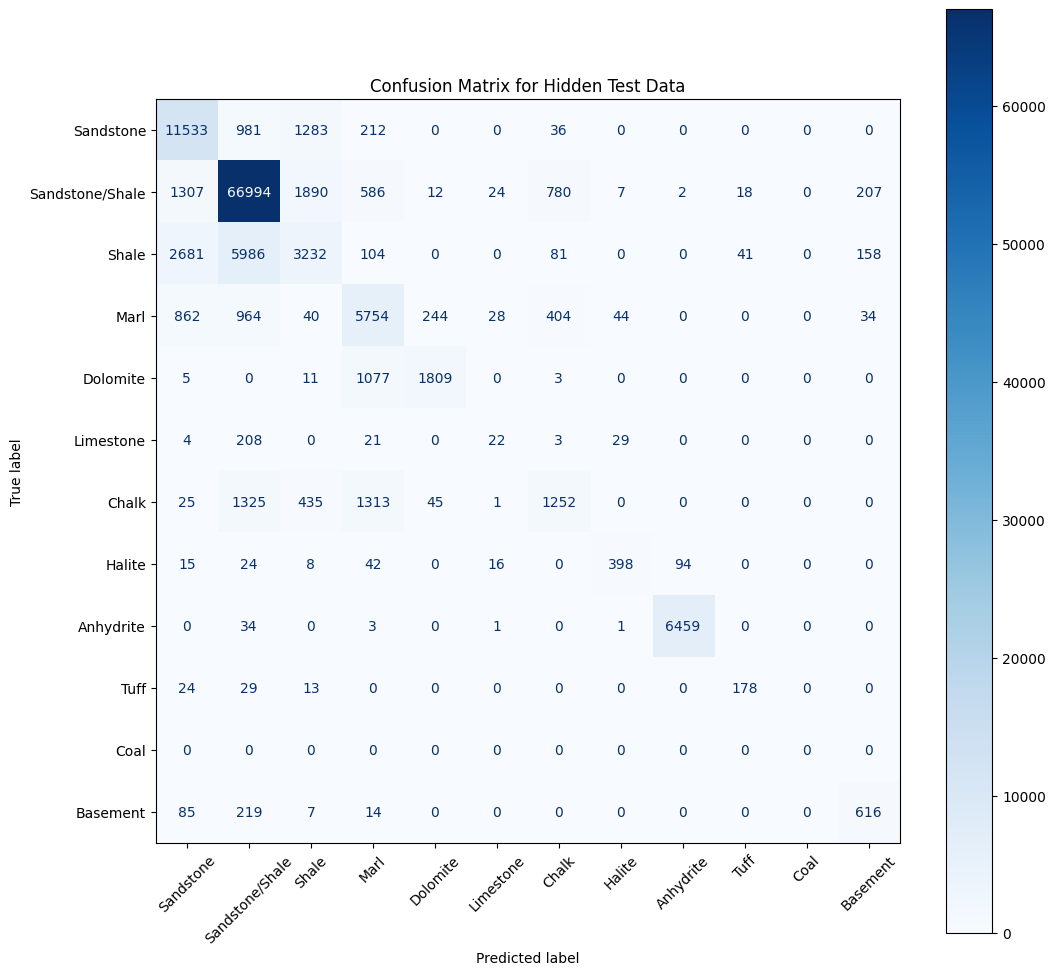

In [8]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

# Classification Report
labels = [x for x in range(len(lithology_codes))]

print("Classification Report for Hidden Test Data:")
print(classification_report(y_hidden_encoded, y_hidden_pred, target_names=display_labels, labels=labels))

# Confusion Matrix
cm_hidden = confusion_matrix(y_hidden_encoded, y_hidden_pred, labels=labels)
disp_hidden = ConfusionMatrixDisplay(confusion_matrix=cm_hidden, display_labels=display_labels)

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(12, 12))
disp_hidden.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix for Hidden Test Data")
plt.show()

### Log Diagrams

#### Load Well True and Predicted Data

In [10]:
import matplotlib.pyplot as plt

# Select a specific well from hidden dataset
well_name = test_df['WELL'].unique()[0]  # Select first well, or specify name
well_data = test_df[test_df['WELL'] == well_name]

# Get predictions for this well
X_well = well_data.drop(columns=["FORCE_2020_LITHOFACIES_LITHOLOGY", "FORCE_2020_LITHOFACIES_CONFIDENCE"])
y_well_true = well_data["FORCE_2020_LITHOFACIES_LITHOLOGY"]
y_well_pred = pipeline.predict(X_well)

#### Draw Plots

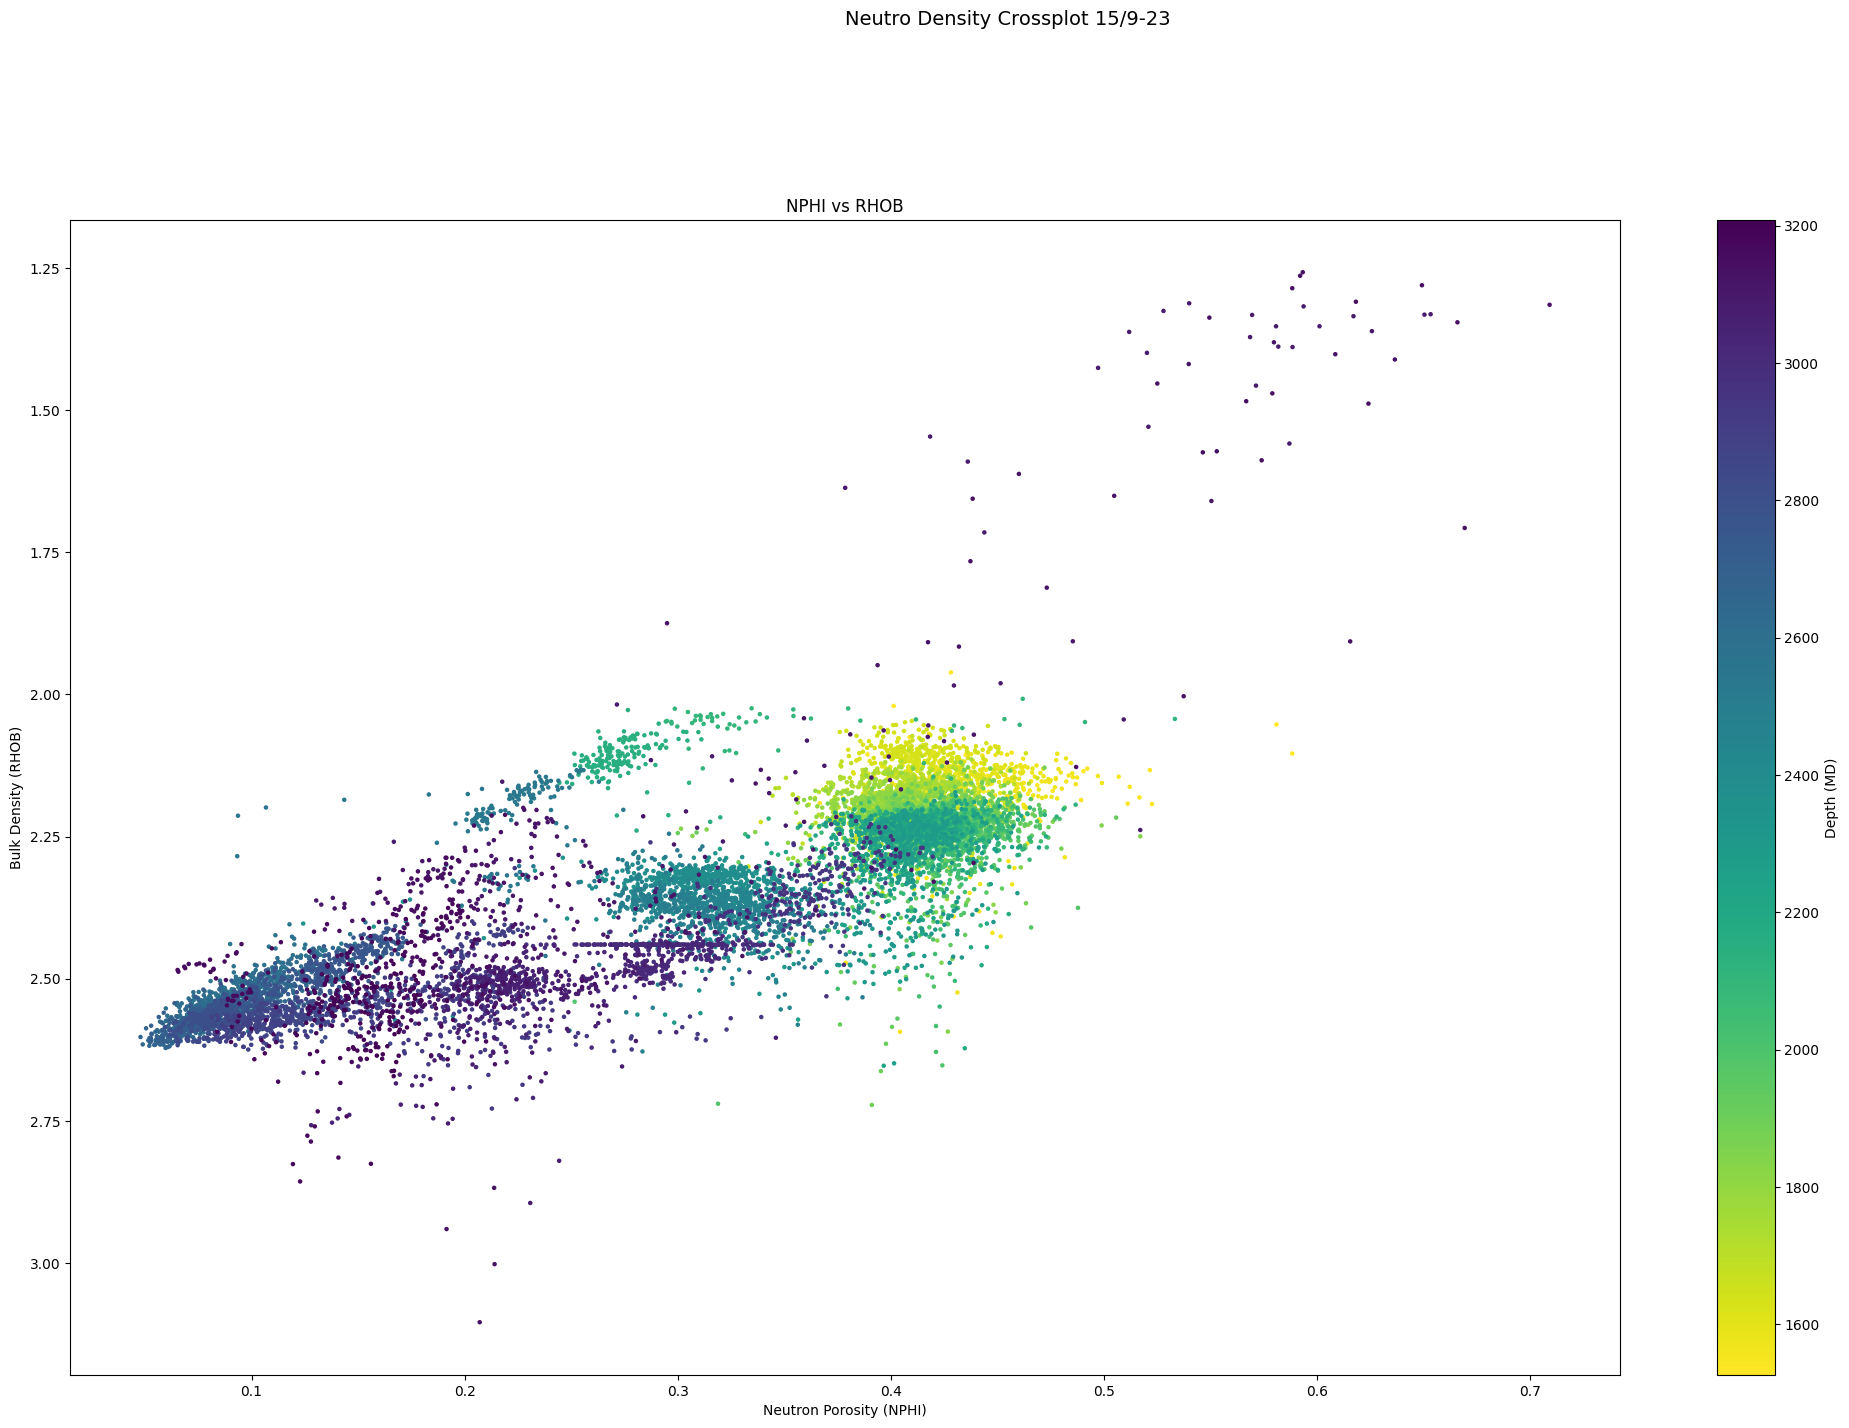

In [12]:
# Plot 6: Neutron-Density Crossplot
fig, ax = plt.subplots(figsize=(25, 15))
plt.suptitle(f'Neutro Density Crossplot {well_name}', y=1.02, fontsize=14)
fig.subplots_adjust(wspace=0.1)

sc = ax.scatter(well_data['NPHI'], well_data['RHOB'], c=depth, cmap='viridis_r', s=5)
ax.set_title('NPHI vs RHOB')
ax.set_xlabel('Neutron Porosity (NPHI)')
ax.set_ylabel('Bulk Density (RHOB)')
ax.invert_yaxis()
plt.colorbar(sc, ax=ax, label='Depth (MD)')

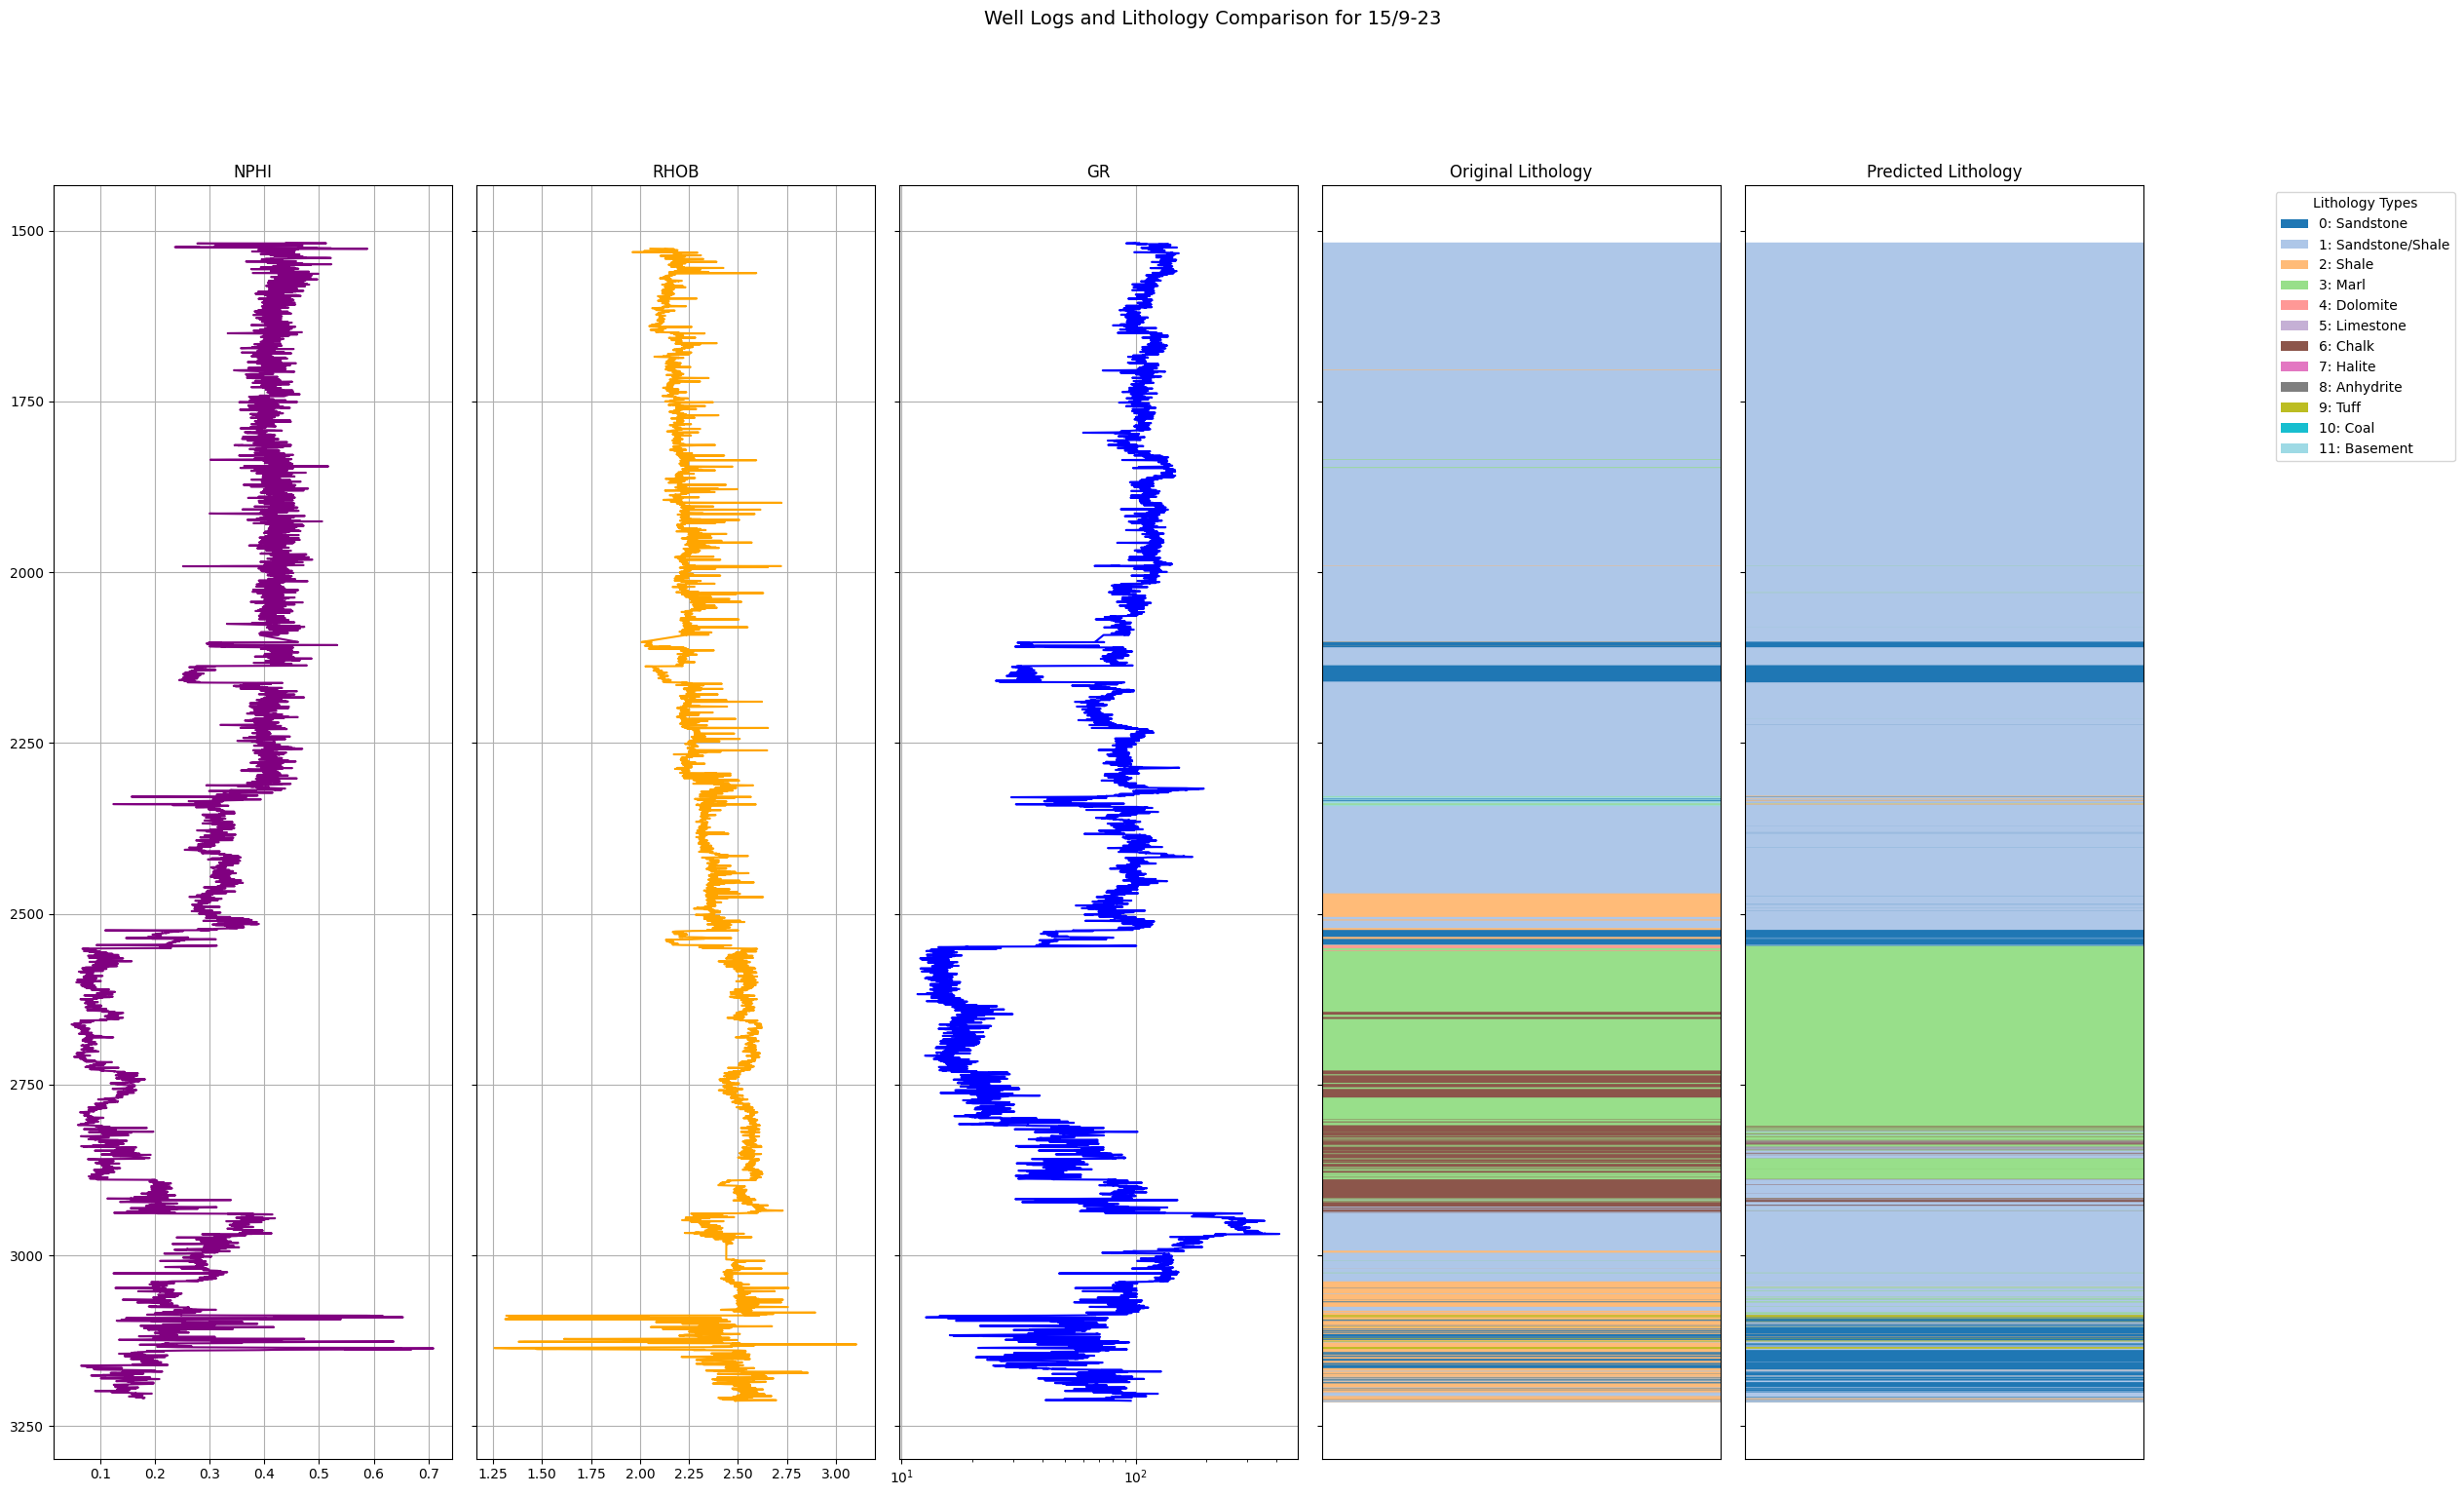

In [13]:
# Logs we will use
logs = ["NPHI", "RHOB", "GR"]
# Colors for each log
colors = ['purple', 'orange', 'blue']

# Create the subplots with shared y-axis
fig, ax = plt.subplots(1, 5, figsize=(25, 15), sharey=True)
plt.suptitle(f'Well Logs and Lithology Comparison for {well_name}', y=1.02, fontsize=14)
fig.subplots_adjust(wspace=0.1)

# Set common depth range
depth = well_data['DEPTH_MD']

# GR, SP, and DTC Logs
for i in range(len(logs)):
    log_data = well_data[logs[i]]
    
    if i == 2:
        # Resistivity log on a semilog plot
        ax[i].semilogx(log_data, depth, color=colors[i])
    else:
        ax[i].plot(log_data, depth, color=colors[i])
    
    ax[i].set_title(logs[i])
    ax[i].invert_yaxis()  # Invert y-axis for each subplot
    ax[i].grid()


# Create color mapping for lithology classes
unique_classes = labels
cmap = plt.get_cmap('tab20', len(unique_classes))
color_dict = {cls: cmap(i) for i, cls in enumerate(unique_classes)}

# Plot 3: Original Lithology
for i, (start, end) in enumerate(zip(depth[:-1], depth[1:])):
    ax[3].fill_betweenx([start, end], 0, 1, 
                        color=color_dict[le.transform([y_well_true.iloc[i]])[0]])
ax[3].set_title('Original Lithology')
ax[3].set_xlim(0, 1)
ax[3].set_xticks([])

# Plot 4: Predicted Lithology
for i, (start, end) in enumerate(zip(depth[:-1], depth[1:])):
    ax[4].fill_betweenx([start, end], 0, 1, 
                        color=color_dict[y_well_pred[i]])
ax[4].set_title('Predicted Lithology')
ax[4].set_xlim(0, 1)
ax[4].set_xticks([])

# Create legend with original lithology names
legend_elements = [matplotlib.patches.Patch(facecolor=color_dict[cls], 
                   label=f'{cls}: {lithology_keys[lithology_codes[cls]]}')
                 for cls in unique_classes]

ax[-1].legend(handles=legend_elements, bbox_to_anchor=(1.8, 1), 
            loc='upper right', title='Lithology Types')

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the title position
plt.show()

### SHAP Analysis

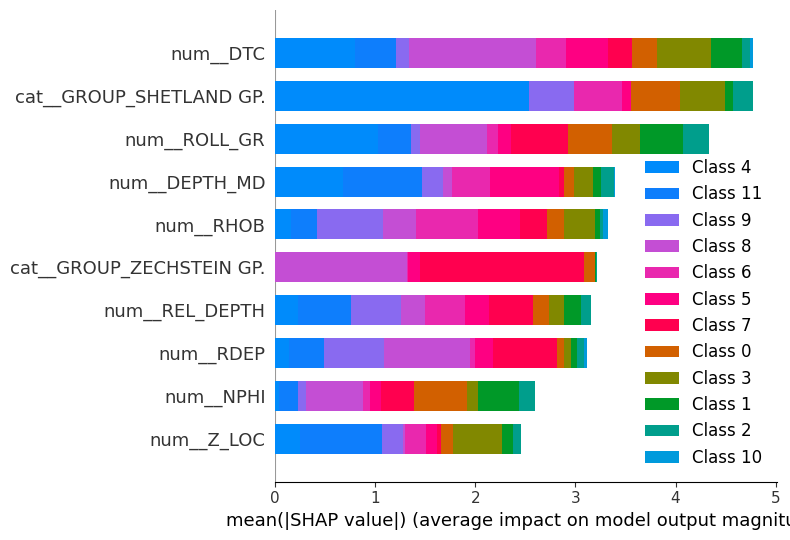

In [14]:
import shap

X_sampled = X_hidden.sample(100, random_state=10)
X_sampled_processed = pipeline[0].transform(X_sampled)

explainer = shap.TreeExplainer(pipeline.named_steps['classifier'])
shap_values = explainer.shap_values(X_sampled_processed)

shap.summary_plot(shap_values, feature_names=pipeline.named_steps['preprocessor'].get_feature_names_out(), 
                  max_display=10,  plot_type='bar')